# RetinaMNIST with rotations

In this exercise your goal will be to solve an object detection training and prediction task using the anchor-based approach.
**As a part of your solution you should provide a report summarizing your findings and results of the conducted experiments.**

##TLDR; overview

In this task one should:
- determine the size of the feasible anchors for the object detection task posed in this Assignment,
- build an object detection model using the variant of `RetinaNet`,
- prepare a matching suite which will match predicted anchors with ground truth bounding boxes,
- train an object detection model using a variant of `RetinaLoss`.

Hints and comments:

- Model architecture and loss are heavily inspired by [RetinaNet](https://arxiv.org/pdf/1708.02002.pdf) paper,
- you can freely subclass and extend the interface of classes in this exercise,
- be sure that you understand the concept of an anchor for object detection, covered during the lecture about Object Detection. There are many great tutorials and articles about it (e.g. [this](https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9) one, note however that we are not implementing ignoring boxes for simplicity).

### Data description

In this task we will paste bounding boxes with digits **from 1 to 5** randomly selected from `MNIST` dataset on a canvas of size `(128, 128)` and **randomly flipped by 90 degrees**. We assume that:

- the two boxes from a canvas should have no more than `0.1` of `iou` overlap,
- the digits are fully contained in canvas,
- boxes are modeled using `MnistBox` class,
- canvas is modeled using `MnistCanvas` class.

Let us have a look at definition of these classes:

In [ ]:
from typing import List
from typing import Optional
from typing import Tuple

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MnistBox:

    def __init__(
        self,
        x_min: int,
        y_min: int,
        x_max: int,
        y_max: int,
        class_nb: Optional[int] = None,
        rotated: Optional[bool] = None,
    ):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.class_nb = class_nb
        self.rotated = rotated
    
    @property
    def x_diff(self):
        return self.x_max - self.x_min
    
    @property
    def y_diff(self):
        return self.y_max - self.y_min

    def __repr__(self):
        return f'Mnist Box: x_min = {self.x_min},' +\
               f' x_max = {self.x_max}, y_min = {self.y_min},' +\
               f' y_max = {self.y_max}. Class = {self.class_nb}.' +\
               f' Rotated = {self.rotated}.'

    def plot_on_ax(self, ax, color: Optional[str] = 'r'):
        if type(self.y_min) == torch.Tensor:
            ax.add_patch(
                patches.Rectangle(
                    (self.y_min.to('cpu'), self.x_min.to('cpu')),
                     self.y_diff.to('cpu'),
                     self.x_diff.to('cpu'),
                     linewidth=1,
                     edgecolor=color,
                     facecolor='none',
                )
            )
            ax.text(
                self.y_min,
                self.x_min,
                f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
                bbox={"facecolor": color, "alpha": 0.4},
                clip_box=ax.clipbox,
                clip_on=True,
            )
        else:
            ax.add_patch(
                patches.Rectangle(
                    (self.y_min, self.x_min),
                     self.y_diff,
                     self.x_diff,
                     linewidth=1,
                     edgecolor=color,
                     facecolor='none',
                )
            )
            ax.text(
                self.y_min,
                self.x_min,
                f'{self.class_nb}' if not self.rotated else f'{self.class_nb}*',
                bbox={"facecolor": color, "alpha": 0.4},
                clip_box=ax.clipbox,
                clip_on=True,
            )

    @property
    def area(self):
        return max((self.x_max - self.x_min), 0) * max((self.y_max - self.y_min), 0)

    def iou_with(self, other_box: "MnistBox"):
        aux_box = MnistBox(
            x_min=max(self.x_min, other_box.x_min),
            x_max=min(self.x_max, other_box.x_max),
            y_min=max(self.y_min, other_box.y_min),
            y_max=min(self.y_max, other_box.y_max),
        ) 
        return aux_box.area / (self.area + other_box.area - aux_box.area)


class MnistCanvas:

    def __init__(
        self,
        image: np.ndarray,
        boxes: List[MnistBox],
    ):
        self.image = image
        self.boxes = boxes

    def add_digit(
        self,
        digit: np.ndarray,
        class_nb: int,
        x_min: int,
        y_min: int,
        rotated=None,
        iou_threshold=0.1,
    ) -> bool:
        """
        Add a digit to an image if it does not overlap with existing boxes
        above iou_threshold.
        """
        image_x, image_y = digit.shape
        if x_min >= self.image.shape[0] and y_min >= self.image.shape[1]:
            raise ValueError('Wrong initial corner box')
        new_box_x_min = x_min
        new_box_y_min = y_min
        new_box_x_max = min(x_min + image_x, self.image.shape[0])
        new_box_y_max = min(y_min + image_y, self.image.shape[1])
        new_box = MnistBox(
            x_min=new_box_x_min,
            x_max=new_box_x_max,
            y_min=new_box_y_min,
            y_max=new_box_y_max,
            class_nb=class_nb,
            rotated=rotated,
        )
        old_background = self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ]
        for box in self.boxes:
            if new_box.iou_with(box) > iou_threshold:
                return False
        self.image[
            new_box_x_min:new_box_x_max,
            new_box_y_min:new_box_y_max
        ] = np.maximum(old_background, digit)
        self.boxes.append(
            new_box
        ) 
        return True
        
    def get_torch_tensor(self) -> torch.Tensor:
        np_image = self.image.astype('float32')
        np_image = np_image.reshape(
            (1, 1, self.image.shape[0], self.image.shape[1])
        )
        return torch.from_numpy(np_image).to(DEVICE)

    @classmethod
    def get_empty_of_size(cls, size: Tuple[int, int]):
        return cls(
            image=np.zeros(size),
            boxes=[],
        )

    def plot(self, boxes: Optional[List[MnistBox]] = None):
        fig, ax = plt.subplots()
        ax.imshow(self.image)
        boxes = boxes or self.boxes
        for box in boxes:
            box.plot_on_ax(ax)
        plt.show()

Each canvas has 3-6 boxes with randomly selected digits. The digits for training data are from first 10K examples from `MNIST` train data. The digits for test data are selected from first 1K examples from `MNIST` test data. The Dataset is generated using the following functions:

In [ ]:
from keras.datasets import mnist
import numpy as np


mnist_data = mnist.load_data()
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist_data


def crop_insignificant_values(digit:np.ndarray, threshold=0.1):
    bool_digit = digit > threshold
    x_range = bool_digit.max(axis=0)
    y_range = bool_digit.max(axis=1)
    start_x = (x_range.cumsum() == 0).sum()
    end_x = (x_range[::-1].cumsum() == 0).sum()
    start_y = (y_range.cumsum() == 0).sum()
    end_y = (y_range[::-1].cumsum() == 0).sum()
    return digit[start_y:-end_y - 1, start_x:-end_x - 1]


TRAIN_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_train[:10000])
]
TRAIN_CLASSES = mnist_y_train[:10000]

TEST_DIGITS = [
    crop_insignificant_values(digit) / 255.0
    for digit_index, digit in enumerate(mnist_x_test[:1000])
]
TEST_CLASSES = mnist_y_test[:1000]


def get_random_canvas(
    digits: Optional[List[np.ndarray]] = None,
    classes: Optional[List[int]] = None,
    nb_of_digits: Optional[int] = None,
    ):
    digits = digits if digits is not None else TRAIN_DIGITS
    classes = classes if classes is not None else TRAIN_CLASSES
    nb_of_digits = nb_of_digits if nb_of_digits is not None else np.random.randint(low=3, high=6 + 1)
    new_canvas = MnistCanvas.get_empty_of_size(size=(128, 128))
    attempts_done = 0
    while attempts_done < nb_of_digits:
        current_digit_index = np.random.randint(len(digits))
        current_digit_class = classes[current_digit_index]
        if current_digit_class not in [1, 2, 3, 4, 5]:
            continue
        rotate = np.random.random() > 0.5
        current_digit = digits[current_digit_index]
        if rotate:
            current_digit = np.rot90(current_digit)
        random_x_min = np.random.randint(0, 128 - current_digit.shape[0] - 3)
        random_y_min = np.random.randint(0, 128 - current_digit.shape[1] - 3)
        if new_canvas.add_digit(
            digit=current_digit,
            x_min=random_x_min,
            y_min=random_y_min,
            class_nb=current_digit_class,
            rotated=rotate,
        ):
            attempts_done += 1
    return new_canvas

2021-12-15 11:04:11.802171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 11:04:11.802187: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Let us have a look at example canvas (rotated digits have additional *added to description).

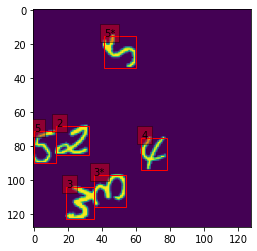

In [ ]:
mnist_canvas = get_random_canvas()
mnist_canvas.plot()

Now - let us generate test canvas:

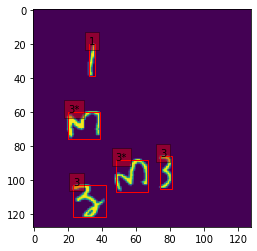

In [ ]:
TEST_CANVAS_SIZE = 256
TEST_SEED = 42 # DO NOT CHANGE THIS LINE.

np.random.seed(TEST_SEED)

TEST_CANVAS = [
    get_random_canvas(
        digits=TEST_DIGITS,
        classes=TEST_CLASSES,
    )
    for _ in range(TEST_CANVAS_SIZE)
]

TEST_CANVAS[0].plot()

For training one can either:
- generate `TRAIN_CANVAS` similarly to `TEST_CANVAS` creation,
- use the fact that `get_random_canvas()` generates a random train canvas and generate training data on-the-fly.

### Anchor size analysis (2pts)

For this task:
1. Sample at least 1000 random canvas.
2. Analyze the sizes (heights and widths) of the `MnistBox`es from this canvas.
3. Select the anchor sizes which will match the problem the best.

Selected anchor sizes should be stored in a sensible manner in `ANCHOR_SIZES` list.

ANCHOR_SIZES:
[(9, 19),
 (19, 9),
 (11, 19),
 (19, 11),
 (13, 19),
 (19, 13),
 (15, 19),
 (19, 15),
 (17, 19),
 (19, 17),
 (19, 19)]


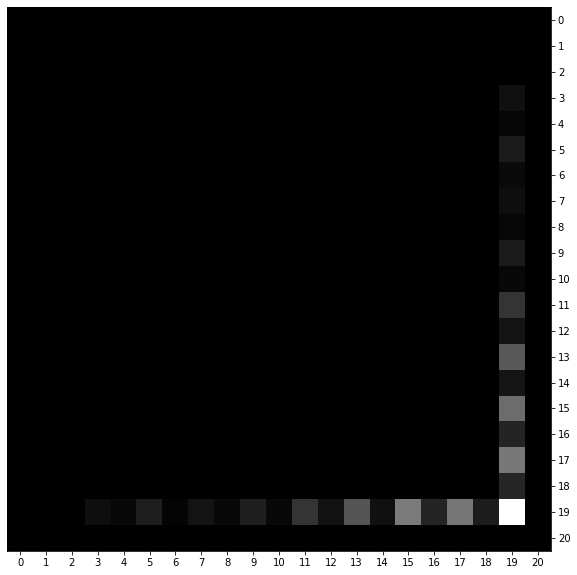

In [ ]:
import collections
import matplotlib.pyplot as plt
import pprint

heatmap = np.zeros((21, 21))
for i in range(1000):
  canvas = get_random_canvas()
  for box in canvas.boxes:
    height = box.y_diff
    width = box.x_diff
    heatmap[width, height] += 1

plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
im = ax.imshow(heatmap, cmap='gray', interpolation='nearest')
ax.set_xticks(np.arange(21))
ax.set_yticks(np.arange(21))
ax.yaxis.tick_right()

ANCHOR_SIZES = [] # TODO
for other in range(9, 19, 2):
  ANCHOR_SIZES.append((other, 19))
  ANCHOR_SIZES.append((19, other))
ANCHOR_SIZES.append((19, 19))
print("ANCHOR_SIZES:") 
pprint.pprint(ANCHOR_SIZES)
NUM_ANCHORS = len(ANCHOR_SIZES)
plt.rcParams['figure.figsize'] = [5, 5]

### Model building (2pt)


One should build a model for digit detection in $\texttt{pytorch}$. Model should consist of:

#### $\texttt{backbone}$:

We provided you with a backbone model architecture that accepts a `MnistCanvas` instance and output a tensor with shape $(1, 16, 16, 128)$. It should be trained together with the rest of your solution.

#### $\texttt{anchors}$:

List of `MnistBox`es where each box:

- should have size of one of selected `ANCHOR_SIZES`,
- should have center coordinates on canvas of type $\left(\left(m + \frac{1}{2}\right) * 8, \left(n + \frac{1}{2}\right) * 8\right)$  for $m, n \in \{0, 1, \dots, 16 - 1\}$,

`MnistBox` with anchor should have an attribute `class_nb` set to `None`.

#### $\texttt{digitClassificationHead}$:

$\texttt{digitClassificationHead}$ should accept backbone output as an input and output `digit_classification_output` tensor of shape $(len(\texttt{anchors)}, 5)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit of class $j + 1$ (ground truth box).

#### $\texttt{rotationClassificationHead}$:

$\texttt{rotationClassificationHead}$ should accept backbone output as an input and output `rotation_classification_output` tensor of shape $(len(\texttt{anchors)}, 2)$ where the value $ch_{i, j}$ which is the value of i-th row and j-th column has a property that $sigmoid(ch_{i, j})$ is a probability that i-th anchor from $\texttt{anchors}$ overlaps significantly with some canvas `GTBox: MnistBox` with a digit which was not rotated when $j = 0$ and was rotated when $j = 1$.

#### $\texttt{boxRegressionHead}$:

$\texttt{boxRegressionHead}$ should accept backbone output as an input and output `box_regression_output` tensor of shape $(len(\texttt{anchors)}, 4)$ where the value $br_{i}$ which is the value of i-th row has a property that if there is a ground truth digit box $\texttt{GTBox}$ - significantly overlapping with $\texttt{anchor}[i]$ then the following properties hold:

$$\texttt{GTBox.x_min} = \texttt{anchor[i].x_min} + br_{i, 0},$$ 
$$\texttt{GTBox.x_max} = \texttt{anchor[i].x_max} + br_{i, 1},$$ 
$$\texttt{GTBox.y_min} = \texttt{anchor[i].y_min} + br_{i, 2},$$ 
$$\texttt{GTBox.y_max} = \texttt{anchor[i].y_max} + br_{i, 3}.$$ 

#### *Hint*: be careful with a construction of a head output as a simple reshaping might cause unexpected permutation of anchors.

### Model output

Model should output `DigitDetectionModelOutput` class defined below.

#### Comment on _significant overlap_:

The meaning of significant overlap will be described later.

In [ ]:
from torch import nn
import torch.nn.functional as F

class DigitDetectionModelOutput:

    def __init__(
        self,
        anchors: List[MnistBox],
        digit_classification_output: torch.Tensor,
        rotation_classification_output: torch.Tensor,
        box_regression_output: torch.Tensor,
    ):
        self.anchors = anchors
        self.digit_classification_output = digit_classification_output
        self.box_regression_output = box_regression_output
        self.rotation_classification_output = rotation_classification_output


class Backbone(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output_shape = (16, 16, 128)
        self.first_block = torch.nn.Sequential(
            nn.Conv2d(1, 16, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.blocks = torch.nn.ModuleList(
            [torch.nn.Sequential(*[
                nn.Conv2d(16 * (2 ** i), 16 * (2 ** (i + 1)), (3, 3), padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
              ]) for i in range(1, 3)
            ]
        )

    def forward(self, x: MnistCanvas) -> torch.Tensor:
        image = torch.Tensor(x.image).to(DEVICE).view(1, 1, 128, 128)
        aux = self.first_block(image)
        for block in self.blocks:
            aux = block(aux)
        return aux

class DigitDetectionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone()
        self.anchors = []
        for m in range(3, 128, 8):
          for n in range(3, 128, 8):
            for anchor in ANCHOR_SIZES:
              x, y = anchor
              box = MnistBox(m - x//2, n - y//2, m+x//2, n+y//2, class_nb=None)
              self.anchors.append(box)
        
        self.digitClassificationHead = Head(128, NUM_ANCHORS, 5)
        self.rotationClassificationHead = Head(128, NUM_ANCHORS, 2)
        self.boxRegressionHead = Head(128, NUM_ANCHORS, 4)

    def forward(self, x: MnistCanvas) -> DigitDetectionModelOutput:
        b_res = self.backbone(x)
        d_class = self.digitClassificationHead(b_res)
        r_class = self.rotationClassificationHead(b_res)
        box_regression = self.boxRegressionHead(b_res)
        return DigitDetectionModelOutput(self.anchors, d_class, r_class, box_regression)

class Head(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        '''num_anchors - number of anchors per single anchoring point. Total number of anchors in whole model is equal to 16 x 16 x num_anchors'''
        super().__init__()

        conv = []
        conv.append(nn.Conv2d(in_channels, in_channels, kernel_size=5, stride=1, padding=2))
        conv.append(nn.ReLU())
        for _ in range(3):
            conv.append(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1))
            conv.append(nn.ReLU())
        self.conv = nn.Sequential(*conv)

        self.cls_logits = nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=3, stride=1, padding=1)

        self.num_classes = num_classes
        self.num_anchors = num_anchors

    def forward(self, x):
        x = self.conv(x)
        result = self.cls_logits(x)
        result.squeeze_()
        result = result.permute(1, 2, 0)
        return result.reshape(256 * self.num_anchors, self.num_classes)


### Significant overlap (4pt)

In order to manage definition of a _significant overlap_ student should implement the `TargetDecoder`. `TargetDecoder` have two methods:

### - `get_targets`

This method accepts a `canvas: MnistCanvas` with boxes later refered to as `gt_boxes: List[MnistBox]`, `anchors: List[MnistBox]` of model anchors and `iou_threshold: float`. Its output should be `DigitDetectionModelTarget` instance with the following attributes:

- `digit_classification_target` - a tensor of shape $(len(anchors), 5)$,
- `rotation_classification_target` - a tensor of shape $(len(anchors), 2)$
- `box_regression_target` - a tensor of shape $(len(anchors), 4)$,
- `matched_anchors` - a list of indices anchors matched (see definition below).

The output attributes should be computed in a following manner: 

1. All of the outputs of the output tensors should be `0` except the case presented in the point 2.
1. if for anchor `anchors[i]` there exist at least one `gt_box` from `gt_boxes` with `iou` overlap greater than `iou_threshold` then let `gt_best` be the one with the greatest `iou` overlap (ties resolved randomly). Then `box_regression_target` should encode the bounding box correction, namely:

$$\texttt{box_regression_target}[i, 0] = \texttt{gt_best.x_min} - \texttt{anchor[i].x_min}$$ 
$$\texttt{box_regression_target}[i, 1] = \texttt{gt_best.x_max} - \texttt{anchor[i].x_max}$$ 
$$\texttt{box_regression_target}[i, 2] = \texttt{gt_best.y_min} - \texttt{anchor[i].y_min}$$ 
$$\texttt{box_regression_target}[i, 3] = \texttt{gt_best.y_max} - \texttt{anchor[i].y_max}$$,

`digit_classification_target` should encode the class of matched `gt_best`, namely:

$$\texttt{digit_classification_target}[i, \texttt{gt_best.class_nb} - 1] = 1.$$

`rotation_classification_target` should encode if matched `gt_best` has a digit which was rotated, namely:

$$\texttt{rotation_classification_target}[i, 0] = 1,$$

if `gt_best` digit was not rotated and:

$$\texttt{rotation_classification_target}[i, 1] = 1,$$

if `gt_best` digit was rotated (this might be interpreted as a one-hot encoding if a digit was rotated).

Moreover - the `anchor[i]` is considered to be _matched_ with some ground truth box so index `i` should be in `matched_anchors` list.

The output should be packed into `DigitDetectionModelTarget` class defined below.

_Hint_: note that there might be cases when no anchor is matched. What does it mean about your anchors?

### - `get_predictions`

This method should decode the `DigitDetectionModelOutput` to set of final boxes
predictions. We leave the way of selecting the predictions to students.

_HINT_: we definitely advise to use `torchvision.ops.nms` function.



In [ ]:
from torchvision.ops import box_iou, nms

class DigitDetectionModelTarget:

    def __init__(
        self,
        digit_classification_target: torch.Tensor,
        rotation_classification_target: torch.Tensor,
        box_regression_target: torch.Tensor,
        matched_anchors: List[int],
    ):
        self.digit_classification_target = digit_classification_target
        self.rotation_classification_target = rotation_classification_target
        self.box_regression_target = box_regression_target
        self.matched_anchors = matched_anchors


class TargetDecoder:

    def get_targets(
        self,
        canvas: MnistCanvas,
        anchors: List[MnistBox],
        iou_threshold: float=0.2,
        nb_of_classes: int = 5,
    ) -> DigitDetectionModelTarget:
        digit_classification_target = torch.zeros([len(anchors), 5]).to(DEVICE)
        rotation_classification_target = torch.zeros([len(anchors), 2]).to(DEVICE)
        box_regression_target = torch.zeros([len(anchors), 4]).to(DEVICE)
        matched_anchors = []
        for anchor_no, anchor in enumerate(anchors):
          best_iou = -1
          best_box = None
          for box in canvas.boxes:
            iou = anchor.iou_with(box)
            if iou > iou_threshold and iou > best_iou:
              best_box = box
              best_iou = iou
          if best_box is not None:
            matched_anchors.append(anchor_no)
            digit_classification_target[anchor_no, best_box.class_nb - 1] = 1
            rotation_classification_target[anchor_no, int(best_box.rotated)] = 1
            box_regression_target[anchor_no, 0] = best_box.x_min - anchor.x_min
            box_regression_target[anchor_no, 1] = best_box.x_max - anchor.x_max
            box_regression_target[anchor_no, 2] = best_box.y_min - anchor.y_min
            box_regression_target[anchor_no, 3] = best_box.y_max - anchor.y_max
        return DigitDetectionModelTarget(digit_classification_target, rotation_classification_target, box_regression_target, matched_anchors)


    def get_predictions(
        self,
        model_output: DigitDetectionModelOutput,
    ) -> List[MnistBox]:
        with torch.no_grad():
          n = len(model_output.anchors)
          boxes = torch.zeros([n, 4])
          scores = torch.zeros([n])
          classes = torch.zeros([n])
          rotations = torch.zeros([n], dtype=bool)
          to_eliminate = []
          for i in range(n):
            anchor = model_output.anchors[i]
            class_probability = model_output.digit_classification_output[i, :].softmax(0)
            predicted_class = class_probability.argmax() + 1
            rotation_probability = model_output.rotation_classification_output[i, :].softmax(0)
            predicted_rotation = (rotation_probability.argmax() == 1)
            score = class_probability.max() + rotation_probability.max()
            scores[i] = score
            rotations[i] = predicted_rotation
            classes[i] = predicted_class
            boxes[i, 0] = anchor.x_min + model_output.box_regression_output[i, 0]
            boxes[i, 1] = anchor.y_min + model_output.box_regression_output[i, 2]
            boxes[i, 2] = anchor.x_max + model_output.box_regression_output[i, 1]
            boxes[i, 3] = anchor.y_max + model_output.box_regression_output[i, 3]
            SCORE_THRESHOLD = 1.9999
            if (score < SCORE_THRESHOLD or boxes[i, 0] < 0 or boxes[i, 1] < 0 or boxes[i, 2] <= boxes[i, 0] or boxes[i, 3] <= boxes[i, 1] or boxes[i, 0] >= 128 or boxes[i, 2] >= 128):
              to_eliminate.append(i)
          boxes = boxes.to(DEVICE)
          scores = scores.to(DEVICE)
          classes = classes.to(DEVICE)
          rotations = rotations.to(DEVICE)
          mask = np.zeros([n],dtype=bool)
          mask[to_eliminate] = True
          boxes = boxes[~mask]
          scores = scores[~mask]
          classes = classes[~mask]
          rotations = rotations[~mask]
          to_keep = nms(boxes, scores, 0.1)
          scores_predictions = []
          for i in to_keep:
            scores_predictions.append((scores[i], MnistBox(boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3], classes[i], rotations[i])))

          # Take at most 6 (could be less) most confidently predicted boxes
          scores_predictions.sort(key = lambda t: t[0])
          predictions = [prediction for score, prediction in scores_predictions[-6:]]
          return predictions

### Metrics (4pt)

## Retina Loss
As a loss function one should implement the variant of Retina Loss. It should be computed in a following manner:

`compute_loss`: 

This method accepts:
- `DigitDetectionModelTarget`,
- `DigitDetectionModelOutput`,

and computes a loss which is a sum of a:
- `torch.nn.SmoothL1Loss` between boxes predictions and targets averaged only over matched anchors,
- `torchvision.ops.sigmoid_focal_loss` between digit predictions and targets,
- `torchvision.ops.sigmoid_focal_loss` between rotation predictions and targets,

One can either use `torch` default parameters for this losses or try to tune them.

If there are no matched anchors - a loss should return `None`. Remember to handle this case separately in your training loop. What does the occurence of this case means about your anchors?

## Digit Accuracy

This method shoud accept `canvas: MnistCanvas` and `predicted_boxes: List[MnistBox]` obtained using `TargetDecoder.get_predictions` method and output whether there is a direct matching between boxes from `MnistCanvas` and predictions. There is a direct matching if:

- for all boxes from `canvas`, there exist precisely one box from `predicted_boxes` with a matching class  and `iou` overlap greater than `0.5`,
- the number of `canvas` boxes match `len(predicted_boxes)`.

The model shoud output `1` if there is a matching and `0` otherwise.


In [ ]:
import torch
import torchvision 

class RetinaLoss:

    def compute_loss(
        self,
        model_output: DigitDetectionModelOutput,
        model_target: DigitDetectionModelTarget,
    ) -> Optional[torch.Tensor]:
        matched = model_target.matched_anchors
        if len(matched) == 0:
            return None
        f_loss1 = torch.nn.SmoothL1Loss(reduction='mean')
        loss1 = f_loss1(model_output.box_regression_output[matched], model_target.box_regression_target[matched])
        loss2 = torchvision.ops.sigmoid_focal_loss(model_output.digit_classification_output[matched], model_target.digit_classification_target[matched], reduction='mean')
        loss3 = torchvision.ops.sigmoid_focal_loss(model_output.rotation_classification_output[matched], model_target.rotation_classification_target[matched], reduction='mean') 
        return loss1 + loss2 + loss3


class DigitAccuracy:

    def compute_metric(
        self,
        predicted_boxes: List[MnistBox],
        canvas: MnistCanvas,
    ):
      expected_boxes = canvas.boxes
      if len(predicted_boxes) != len(canvas.boxes):
        return 0 
      for expectation in expected_boxes:
        found_match = False
        for prediction in predicted_boxes:
          if prediction.iou_with(expectation) > 0.5 and prediction.class_nb == expectation.class_nb and prediction.rotated == expectation.rotated:
            if found_match:
              return 0
            else:
              found_match = True
        if not found_match:
          return 0
      return 1

### Train your model (4pt)

One should use all classes defined above to train the model.

A passing threshold is `10%` of a `DigitAccuracy` on a `TEST_CANVAS` data.

Plot example results of matched and mismatched predictions (2pt).

**Hint:** Training can take a while to achieve the expected accuracy. It is normal that for many epochs at the beginning accuracy is constantly $0$. Do not worry as long as the loss is on average decreasing across epochs.

Have fun!

In [ ]:
N = 2048 # No. of examples in train set
BATCH_SIZE = 32

model = DigitDetectionModel()
decoder = TargetDecoder()

# For performance reasons it's better to save all targets beforehand
train_examples = [get_random_canvas() for i in range(N)]
example_target = [(canvas, decoder.get_targets(canvas, model.anchors)) for canvas in train_examples]
test_targets = [decoder.get_targets(canvas, model.anchors) for canvas in TEST_CANVAS]

In [ ]:
import random

def test_loss_report(model, loss_computer, test_targets):
  with torch.no_grad():
    loss = 0
    for example, target in zip(TEST_CANVAS, test_targets):
      model_output = model(example)
      loss += loss_computer.compute_loss(model_output, target).item()
    print(f"Test loss: {loss}, avg: {loss / TEST_CANVAS_SIZE}")


if DEVICE == torch.device('cuda'):
    model.cuda()
loss_computer = RetinaLoss()
EPOCHS = 50
optimizer = torch.optim.Adam(model.parameters(), lr=.03 / BATCH_SIZE)

for i in range(EPOCHS):
  random.shuffle(example_target)
  epoch_loss = 0
  for batch_no in range(N//BATCH_SIZE):
    optimizer.zero_grad()
    batch_loss = 0
    # If N is not a multiple of BATCH_SIZE, the last (not full) batch will be skipped
    # It's not a problem because data is shuffled in each epoch
    for example, target in example_target[batch_no*BATCH_SIZE:(batch_no+1) * BATCH_SIZE]:
      model_output = model(example)
      batch_loss += loss_computer.compute_loss(model_output, target)
    batch_loss.backward()
    optimizer.step()
    epoch_loss += batch_loss.item()
  print(f"Epoch loss: {epoch_loss}, avg: {epoch_loss / N}")
  if i % 10 == (EPOCHS-1) % 10:
      test_loss_report(model, loss_computer, test_targets)

Epoch loss: 5522.201560974121, avg: 2.696387480944395
Epoch loss: 2575.7165756225586, avg: 1.2576741091907024
Epoch loss: 1747.7475624084473, avg: 0.8533923644572496
Epoch loss: 1287.9011182785034, avg: 0.6288579679094255
Epoch loss: 1019.5676221847534, avg: 0.49783575301989913
Epoch loss: 892.3818302154541, avg: 0.4357333155348897
Epoch loss: 837.4216461181641, avg: 0.4088972881436348
Epoch loss: 722.65735912323, avg: 0.35286003863438964
Epoch loss: 610.4491629600525, avg: 0.29807088035158813
Epoch loss: 588.0314474105835, avg: 0.287124730180949
Test loss: 90.23117496073246, avg: 0.35246552719036117
Epoch loss: 534.414614200592, avg: 0.26094463584013283
Epoch loss: 475.5794081687927, avg: 0.23221650789491832
Epoch loss: 452.5087990760803, avg: 0.22095156204886734
Epoch loss: 495.0491180419922, avg: 0.2417232021689415
Epoch loss: 404.50540256500244, avg: 0.1975124035961926
Epoch loss: 384.3084099292755, avg: 0.18765059078577906
Epoch loss: 352.7492651939392, avg: 0.17224085214547813
Ep

In [ ]:
decoder = TargetDecoder()
acc_computer = DigitAccuracy()
print("Final test loss:")
test_loss_report(model, loss_computer, test_targets)

correctly_predicted_examples = []
incorrectly_predicted_examples = []
print("Computing final accuracy, this can take a while...")
for i, example in enumerate(TEST_CANVAS):
  predictions = decoder.get_predictions(model(example))
  metric = acc_computer.compute_metric(predictions, example)
  if metric == 1:
    correctly_predicted_examples.append(example)
  else:
    incorrectly_predicted_examples.append(example)
  if i%10 == 0:
    print('.', end='')
print()
print(f"Test set accuracy: {100*(len(correctly_predicted_examples)/len(TEST_CANVAS))}%")

Final test loss:
Test loss: 57.985745060257614, avg: 0.2265068166416313
Computing final accuracy, this can take a while...
..........................
Test set accuracy: 47.65625%


In [ ]:
torch.save(model.state_dict(), './model.pt')

Correctly predicted sample:


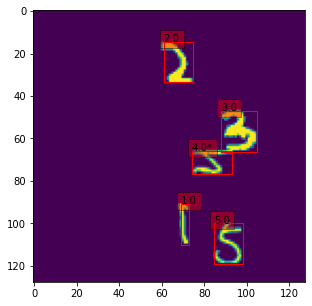

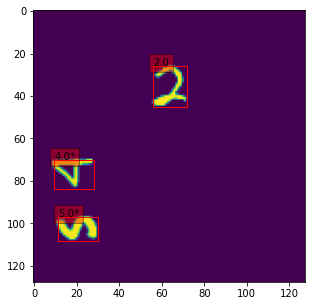

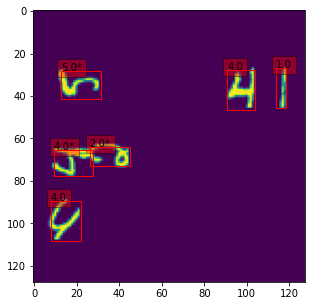

Incorrectly predicted sample:


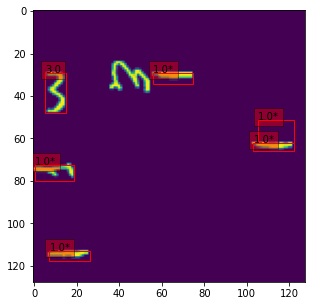

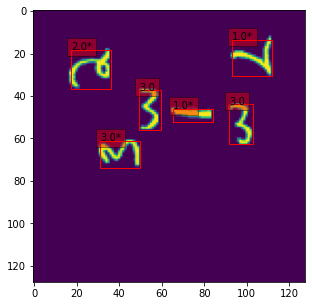

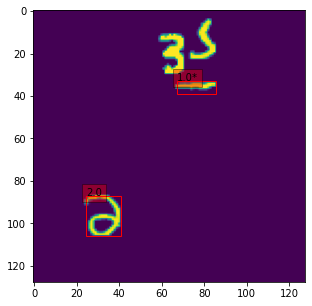

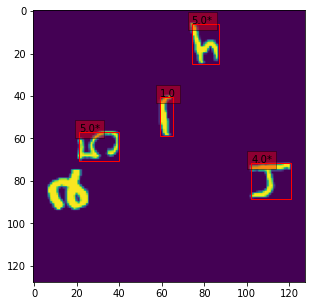

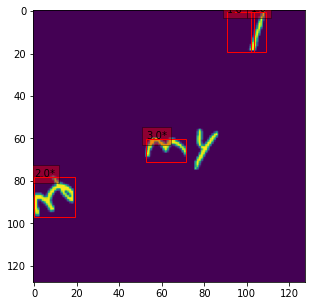

In [ ]:
def predict_and_plot(model, decoder, canvas):
    predictions = decoder.get_predictions(model(canvas))
    MnistCanvas(canvas.image, predictions).plot()

print("Correctly predicted sample:")
correct_predictions_sample = random.sample(correctly_predicted_examples, 3)
for example in correct_predictions_sample:
    predict_and_plot(model, decoder, example)

print("Incorrectly predicted sample:")
incorrect_predictions_sample = random.sample(incorrectly_predicted_examples, 5)
for example in incorrect_predictions_sample:
    predict_and_plot(model, decoder, example)

# Report
## Anchor boxes selection
Based on the heatmap of box sizes in the dataset I concluded that a small set of 11 anchors will do sufficiently good. At first I used more anchors but it seems that enlarging the set does not improve performance by much and slows down learning process.

## Model architecture
My initial attempts at creating a working model architecture were pretty bad, because at first I tried using fully connected layers after backbone. It turned out (which seems obvious to me now) that such model would have really hard time learning and working, since our task is translation-independent.
Later I tried combining ConvNets and fully connected layers with the same result.
My last (and successful) attempt was to mimic the final layers described in RetinaNet paper. In the beginning the net had some troubles with learning because I did not reshape the output correctly, but with proper reshaping the model could finally learn well and fast.

All heads are convnets consisting of 5 layers with the first layer being of kernel size 5 and further ones being of kernel size 3. Activation function used is ReLU.

## Training process
After noticing how time-consuming target creation was, I decided to create a finite train set about 10 times the size of the test set and precompute target boxes for each of the train examples.
To make learning process stable I tried batch sizes of 16 and 32.
SGD (i. e. batch size = 1) was pretty erratic while learning. I stuck with 32 since it worked quite well.
Because I was trying out various batch sizes, I made the learning rate related to the batch size.
Some research I did later suggests that was a bad idea (learning rate should be increased not decreased when batch size is increased), but I did not change the formula once I got the model to work.

Training took less than two hours on a laptop PC utilising a GeForce GTX 1650Ti GPU.


## Getting predictions from model output
### Score - model confidence
To order model predictions from best to worst I compute a score for each of the anchors.

Let $A$ be an anchor. Let $d_1, ..., d_5$ be the model's output predicting the digit for anchor $A$ and $r_1, r_2$ the model's output predicting the rotation (all before softmax).
I set score of anchor $A$ to be $$s:=max(softmax(d_1, ..., d_5)) + max(softmax(r_1, r_2))$$
Maximal possible score would thus be $2$.
### Algorithm
I started out with a simple algorithm for selecting final predictions - I would not allow any overlapping rectangles and always take the six most confident (highest score) predictions. I also rejected any malformed anchors (e. g. $X_{max} < X_{min}$ or $X_{min} < 0$). This turned out not to give good enough results because the images do not always contain six numbers and can overlap. Still, this was a good starting point.

After that I set the maximum IOU overlap to 0.1. It helped my net a little bit, but I was still losing a lot of accuracy on examples with less than 6 images.

I examined a couple of randomly generated images and how high the scores were for correctly and incorrectly predicted boxes.
It turned out that if I set the score threshold to 1.9999 (I would reject boxes with score < 1.9999), my net would do much better.

This is a working solution, but I also suspect the score threshold might need to be changed if, for example, the net architecture or some learning parameters are changed. In other words, prediction selecting algorithm is fitted to a particular model.